# World Data League 2023

## 🎯 Challenge: Avencas Marine Protected Area: Predict the future of the local ecosystem and its species

#### Challenge Provider: City of Cascais

Marine ecosystems face numerous challenges, including overfishing, habitat destruction, pollution, climate change, invasive species, ocean acidification, loss of biodiversity. Addressing these challenges requires a combination of conservation measures, sustainable fishing practices, pollution reduction, habitat restoration, and global efforts to mitigate climate change. It also necessitates collaboration among governments, scientists, conservation organizations, and local communities to protect and sustainably manage marine ecosystems for future generations.

In Cascais, since 2016, some developments have been recorded in the Avencas Marine Protected Area (MPA), and the year 2019 marked significant administrative progress for the management of the protected area, particularly with the first meeting of the Monitoring Committee for this protected area and the establishment of the Municipal Regulations for the Avencas MPA.
Also in 2019, with the completion of the Environmental Management Plan for the Avencas MPA, habitat management measures promote biodiversity in the area.

For this challenge, we aim to develop a comprehensive approach encompassing three key components. Firstly, we seek to create a method capable of identifying the crucial features that significantly impact the coverage of species within the MPA (Marine Protected Area). Secondly, our objective is to establish a scalable forecasting model that utilizes these important features as input, enabling the prediction of future trends in species coverage. Finally, we aim to deliver a user-friendly product in the form of an interactive dashboard, which can be utilized by various stakeholders involved in local policy, research and development, as well as conservation efforts. This product will assist in identifying and addressing biodiversity risks effectively.

By incorporating weather forecasting data, our interactive dashboard has the potential to generate highly accurate predictive insights. Moreover, it can be instrumental in creating contingency plans specifically tailored to different extreme weather scenarios, further enhancing its usefulness and practicality.

To see the demo: https://github.com/mineysm/WDL_2023/blob/main/demo.mp4


## Team: Team K-MENA

## 👥 Authors
* Sara Sabzikari
* Mine Yasemin 

## 💻 Development

In [1]:
# importing relevant dependencies for notebook
# packages
import re
import os
import warnings


import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot as rioplot
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import elapid as ela
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# import the regression module
from pycaret.regression import *
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# preferences
%matplotlib inline
mpl.style.use('ggplot')
warnings.filterwarnings("ignore")

C:\Users\Ruben\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Ruben\AppData\Local\Temp\ipykernel_15804\257569321.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/l

### Assessing Data Quality

In [2]:
# load in the datasets of interest
df_sheet_all = pd.read_excel('cascais_data/AMPA_Data_Sample.xlsx', sheet_name=[0,1,2])
df_sessile = df_sheet_all[0]
df_sessile

Date      Hour  Tide Weather Condition Water temperature (ºC)  \
0    2011-11-28  12:20:00   0.6         Clear sky                     16   
1    2011-11-28  12:35:00   0.6         Clear sky                     16   
2    2011-11-28  10:10:00   0.6         Clear sky                     16   
3    2011-11-28  10:25:00   0.6         Clear sky                     16   
4    2011-11-28  10:40:00   0.6         Clear sky                     16   
...         ...       ...   ...               ...                    ...   
2006 2020-11-16  08:00:00   0.4             Sunny                     18   
2007 2020-11-16  08:00:00   0.4             Sunny                     18   
2008 2020-11-16  08:00:00   0.4             Sunny                     18   
2009 2020-11-16  08:00:00   0.4             Sunny                     18   
2010        NaT       NaN   NaN               NaN                    NaN   

       Sampler Zone Supratidal/Middle Intertidal  Substrate Chthamalus sp.  \
0        AF SF    D                        Supra       Rock              7   
1        AF SF    D                        Supra       Rock              0   
2        AF SF    D                       Medium     Puddle              0   
3        AF SF    D                       Medium       Rock              8   
4        AF SF    D                       Medium       Rock             25   
...        ...  ...                          ...        ...            ...   
2006  AF SF JP    F                       Medium  Rock/Sand             17   
2007  AF SF JP    F                       Medium       Rock             10   
2008  AF SF JP    F                        Supra       Rock              0   
2009  AF SF JP    F                        Supra       Rock              5   
2010       NaN  NaN                          NaN        NaN            NaN   

      ... Alga castanha carnuda Alga castanha tufosa  \
0     ...                   0.0                  0.0   
1     ...                   0.0                  0.0   
2     ...                   0.0                  0.0   
3     ...                   0.0                  0.0   
4     ...                   0.0                  0.0   
...   ...                   ...                  ...   
2006  ...                   0.0                  0.0   
2007  ...                   0.0                  0.0   
2008  ...                   0.0                  0.0   
2009  ...                   0.0                  0.0   
2010  ...                   NaN                  NaN   

      Alga verde/azul - lavanda  Sphacelaria rigidula (pompons castanhos)  \
0                           0.0                                       0.0   
1                           0.0                                       0.0   
2                           0.0                                       0.0   
3                           0.0                                       0.0   
4                           0.0                                       0.0   
...                         ...                                       ...   
2006                        0.0                                       0.0   
2007                        0.0                                       0.0   
2008                        0.0                                       0.0   
2009                        0.0                                       0.0   
2010                        NaN                                       NaN   

      Cystoseira sp.  Laminaria sp.     TOTAL2  observações  Coluna1  Coluna2  
0                  0            0.0       93.3            0        0      0.0  
1                  0            0.0        0.1                     0      0.0  
2                  0            0.0        100            0        0      0.0  
3                  0            0.0       99.5                     0      0.0  
4                  0            0.0      66.45            0        0      0.0  
...              ...            ...        ...          ...      ...      ...  
200

In [3]:
# checking the data quality
df_sessile = df_sessile.drop(columns=['Sampler', 'Coluna1', 'Coluna2', 'observações'])
df_sessile.rename(columns={'Water temperature (ºC)': 'WaterTemperature', 'Weather Condition': 'Weather', 
                           'Supratidal/Middle Intertidal': 'intertidal'}, inplace=True)
# print(df_sessile['Date'].unique())
print(df_sessile['Hour'].unique())
print(df_sessile['Tide'].unique())
print(df_sessile['Weather'].unique())
print(df_sessile['WaterTemperature'].unique())
print(df_sessile['Zone'].unique())
print(df_sessile['intertidal'].unique())
print(df_sessile['Substrate'].unique())


[datetime.time(12, 20) datetime.time(12, 35) datetime.time(10, 10)
 datetime.time(10, 25) datetime.time(10, 40) datetime.time(12, 0)
 datetime.time(12, 15) datetime.time(11, 0) datetime.time(11, 15)
 datetime.time(11, 30) datetime.time(11, 45) datetime.time(12, 55)
 datetime.time(10, 30) datetime.time(10, 50) datetime.time(12, 25)
 datetime.time(12, 45) datetime.time(11, 10) datetime.time(11, 25)
 datetime.time(11, 40) datetime.time(12, 30) datetime.time(9, 30)
 datetime.time(9, 45) datetime.time(10, 0) datetime.time(10, 45)
 datetime.time(13, 30) datetime.time(13, 0) datetime.time(13, 15)
 datetime.time(10, 15) datetime.time(9, 0) datetime.time(9, 15)
 datetime.time(8, 15) datetime.time(8, 30) datetime.time(8, 45)
 datetime.time(11, 5) '09:00' datetime.time(8, 0) datetime.time(8, 40)
 datetime.time(9, 40) datetime.time(9, 20) datetime.time(9, 10)
 datetime.time(8, 20) '09.30' datetime.time(14, 30) nan]
[0.6  0.8  0.9  0.7  0.5  0.4  1.   1.2  0.3  1.1  0.64 0.63 0.38 0.83
 0.36 0.42 0

Firstly, we remove unnecessary columns 'Sampler', 'Coluna1', 'Coluna2', 'observações'.
There are samples in  different formats, for example 'Hour' column is mostly in datetime format but also has a string '09:00'. There are Nan values in 'Weather', 'Zone', 'intertidal' and 'Substrate' columns. 

We clean the data and fix typos here.

In [4]:
# creating a function to clean dataset that runs through

def clean_data(df):
    # removing null or invalid values and columns
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df.dropna(subset=['Date','Hour', 'WaterTemperature', 'Zone', 'intertidal', 'Substrate'], inplace=True)
    df = df.dropna(how='all')

    # replacing strings that include spaces or typos
    df = df[(df_sessile['WaterTemperature'] != '-') & (df_sessile ['WaterTemperature'] != ' ')]
    df['Substrate'] = df['Substrate'].str.replace(' ','')
    df['intertidal'] = df['intertidal'].str.replace(' ','')
    df['Zone'] = df['Zone'].str.replace(' ','')
    df['intertidal'].replace(['Super', 'Medium ', 'Supra '], ['Supra', 'Medium', 'Supra'], inplace=True)
    df = df.reset_index(drop=True)
    bool_series = df.duplicated(keep='last')
    df = df[~bool_series]
    return df

df_sessile = clean_data(df_sessile)

In [5]:
df_sessile.head()

Date      Hour  Tide    Weather WaterTemperature Zone intertidal  \
0 2011-11-28  12:20:00   0.6  Clear sky               16    D      Supra   
1 2011-11-28  12:35:00   0.6  Clear sky               16    D      Supra   
2 2011-11-28  10:10:00   0.6  Clear sky               16    D     Medium   
3 2011-11-28  10:25:00   0.6  Clear sky               16    D     Medium   
4 2011-11-28  10:40:00   0.6  Clear sky               16    D     Medium   

  Substrate Chthamalus sp.  Balanus perforatus  ...  Alga castanha laminada  \
0      Rock              7                 0.0  ...                     0.0   
1      Rock              0                 0.0  ...                     0.0   
2    Puddle              0                 NaN  ...                     0.0   
3      Rock              8                 0.0  ...                     0.0   
4      Rock             25                 0.0  ...                     0.0   

   Alga castanha filamentosa  Alga castanha incrustante  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   Alga castanha carnuda  Alga castanha tufosa  Alga verde/azul - lavanda  \
0                    0.0                   0.0                        0.0   
1                    0.0                   0.0                        0.0   
2                    0.0                   0.0                        0.0   
3                    0.0                   0.0                        0.0   
4                    0.0                   0.0                        0.0   

   Sphacelaria rigidula (pompons castanhos)  Cystoseira sp.  Laminaria sp.  \
0                                       0.0             0.0            0.0   
1                                       0.0             0.0            0.0   
2                                       0.0             0.0            0.0   
3                                       0.0             0.0            0.0   
4                                       0.0             0.0            0.0   

   TOTAL2  
0    93.3  
1     0.1  
2     100  
3    99.5  
4   66.45  

[5 rows x 101 columns]

In [6]:
# create grouped datasets - aggregating columns by organism Kingdom
df_sessile['Animalia'] = df_sessile.iloc[:,8:40].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_sessile['Fungi'] = df_sessile.iloc[:,40:42].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_sessile['Red_Algae'] = df_sessile.iloc[:,42:69].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_sessile['Green_Algae'] = df_sessile.iloc[:,69:86].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_sessile['Brown_Algae'] = df_sessile.iloc[:,86:100].apply(pd.to_numeric, errors='coerce').sum(axis=1)

# creating new total 
df_sessile['total_check'] = df_sessile['Animalia'] + df_sessile['Fungi'] + df_sessile['Red_Algae'] + df_sessile['Green_Algae'] + df_sessile['Brown_Algae']

# validating how many new total is the same as original total column
check = df_sessile['TOTAL2'].apply(pd.to_numeric, errors='coerce').round(1) == df_sessile['total_check'].round(1)
check.value_counts()

True     1951
False      12
dtype: int64

The dataset is now in better condition to be explored and modeled. 

We also want to give a new label to the species based on their organism kingdom. There are 5 kingdoms in the datasets.

In [7]:
mydict = {} 
mylist = np.concatenate([np.ones(len(df_sessile.columns[8:40])), np.ones(len(df_sessile.columns[40:42]))*2, 
                         np.ones(len(df_sessile.columns[42:69]))*3,
                         np.ones(len(df_sessile.columns[69:86]))*4, np.ones(len(df_sessile.columns[86:100]))*5])
mylistnames = df_sessile.columns[8:100]
my_dictionary = {mylistnames[i]: mylist[i] for i in range(len(mylistnames))}

## 🖼️ Visualisations: EDA

#### Coverage by Kingdom 

It's difficult to visualise the coverage of data across all individual species, so we decided to categorise the species into their biological kingdoms; Animalia, Fungi, Green Algae and Brown Algae. This dimension reduction is supported by classification theory, where taxa categorisation were proposed on the basis of statistical measures of overall or phenetic similarity - we assume that this categorisation of the listed species still retains information about the type of species (Christian Thompson, 2009).

[Text(0.5, 0, 'Kingdom'),
 Text(0, 0.5, 'Average Coverage'),
 Text(0.5, 1.0, 'Average Coverage of Kingdom in MPA')]

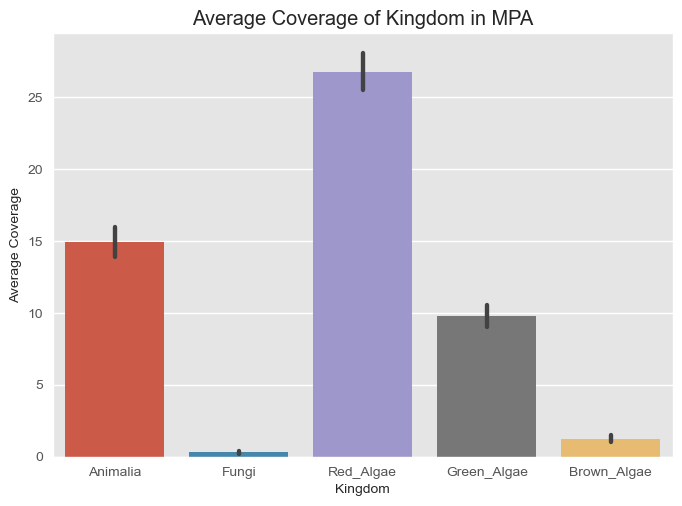

In [8]:
# plotting the average coverage of animals from each animal Kingdom
sessile_grouped = df_sessile[['Date','Animalia','Fungi','Red_Algae','Green_Algae','Brown_Algae']]
melt = pd.melt(sessile_grouped, id_vars=['Date'], value_vars=['Animalia','Fungi','Red_Algae','Green_Algae','Brown_Algae'],
                    var_name='species', value_name='coverage')

ax = sns.barplot(melt,x='species',y='coverage')
ax.set(xlabel='Kingdom',ylabel='Average Coverage',title='Average Coverage of Kingdom in MPA')


#### With Red Algae being the predominant taxa in this data, followed by Animalia and Green Algae, it will be interesting to see the variation in coverage over the years:

In [9]:
# function to change frequenct of data to specified frequency and reshape data
def timeseries_resample(df,freq,aggr):
    df = df[['Date','Animalia','Fungi','Red_Algae','Green_Algae','Brown_Algae']]
    df.loc[:,'Date'] = pd.to_datetime(df['Date']).copy()
    df.set_index('Date', inplace=True)
    if aggr == sum:
        df = df.resample(freq).sum()
    else:
        df = df.resample(freq).mean()
    df.reset_index(inplace=True)
    df = df.groupby('Date').sum().sort_values('Date')
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=['Date'], value_vars=['Animalia','Fungi','Red_Algae','Green_Algae','Brown_Algae'],
                    var_name='species', value_name='coverage')
    
    return df

# applying function to data
monthly_mean = timeseries_resample(df_sessile,'M','mean')
monthly_sum = timeseries_resample(df_sessile,'M',sum)
year_mean = timeseries_resample(df_sessile,'Y','mean')
year_sum = timeseries_resample(df_sessile,'Y',sum)

Text(0.5, 0.98, 'Avg Species Coverage Over Time - Monthly (left), Annually (right)')

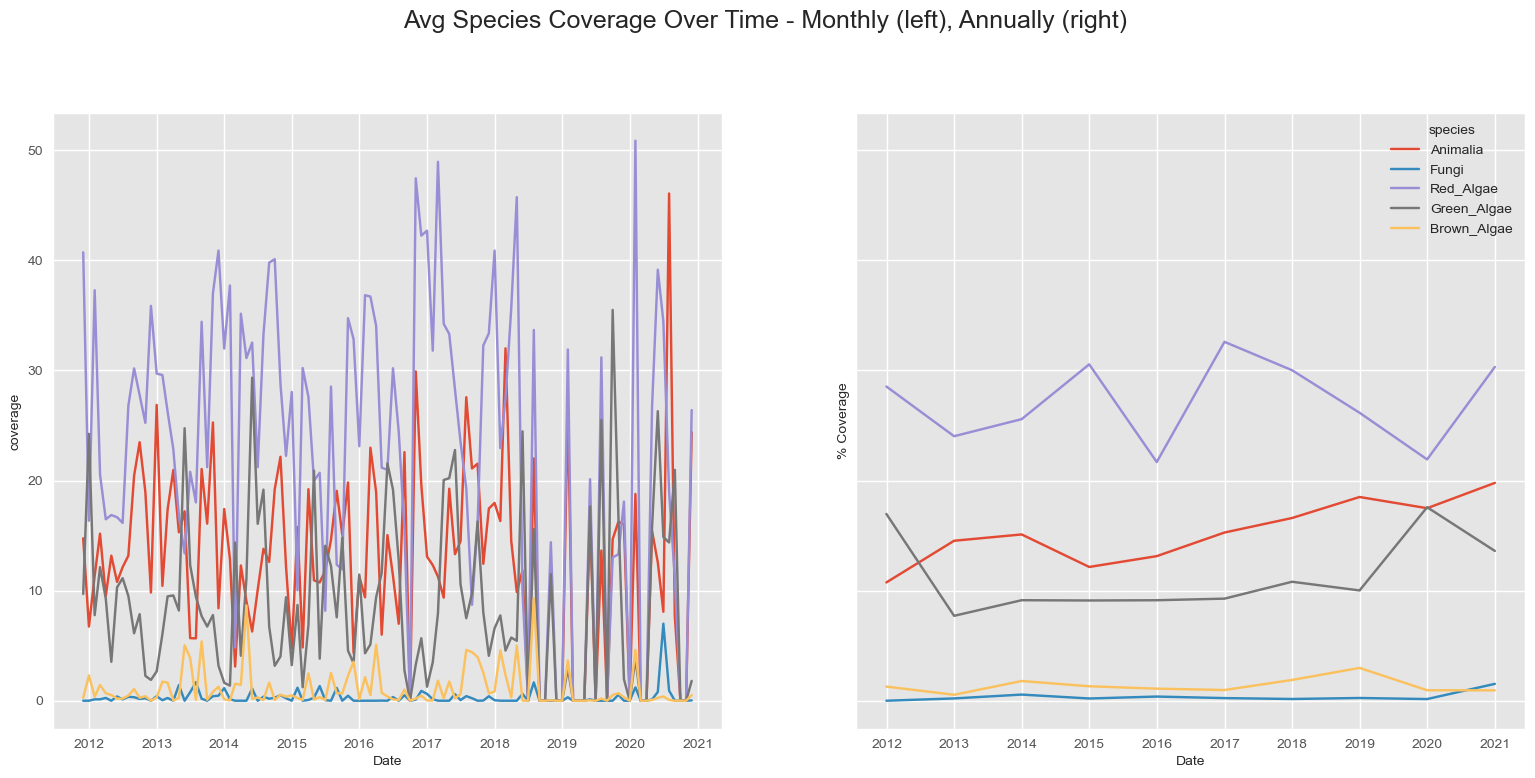

In [10]:
#plot showing average coverage across animal kingdom at two different frequencies

fig,ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
sns.lineplot(monthly_mean, ax=ax[0],x='Date',y='coverage',hue='species',legend=False)
plt.xlabel('Date')
plt.ylabel('% Coverage')

sns.lineplot(year_mean, ax=ax[1],x='Date',y='coverage',hue='species')
plt.xlabel('Date')
plt.ylabel('% Coverage')

fig.suptitle('Avg Species Coverage Over Time - Monthly (left), Annually (right)',va='bottom',size=18)

#### Findings: 

We can see here the normalised total coverage of the species on an annual basis. The highest total coverage for Animalia, Fungi and Red Algae occured before 2014. After 2014 the numbers drop and continue to drop, with the exception of fluctuations. However, the general trend is downwards. While this could be due to other factors other than the recorded 2014 storm.  

In [11]:
# plotting the average coverage by date
sessile_timeseries = df_sessile[['Date','Animalia','Fungi','Red_Algae','Green_Algae','Brown_Algae']]
sessile_timeseries.loc[:,'Date'] = pd.to_datetime(sessile_timeseries['Date']).copy()

# resample data to monthly frequency
sessile_timeseries.set_index('Date', inplace=True)
sessile_yearly_sum = sessile_timeseries.resample('Y').sum()
sessile_yearly_sum.reset_index(inplace=True)
df = sessile_yearly_sum.drop(columns='Date')
date = sessile_yearly_sum['Date']

# normalising the data per column (kingdom)
scaler.fit(df)
normalized_data = scaler.transform(df)
normalized_data = pd.DataFrame(normalized_data)
sessile_yearly_sum = pd.merge(date,normalized_data,left_index=True,right_index=True)

# grouping data by date
sessile_yearly_sum = sessile_yearly_sum.groupby('Date').mean().sort_values('Date')
sessile_yearly_sum.reset_index(inplace=True)
sessile_yearly_sum = pd.melt(sessile_yearly_sum, id_vars=['Date'], value_vars=[0,1,2,3,4],
                    var_name='species', value_name='coverage')

# replacing values with Kingdom names
mapping = {0: 'Animalia', 1: 'Fungi', 2: 'Red_Algae', 3: 'Green_Algae', 4: 'Brown_Algae'}
row = [0, 1, 2, 3, 4]  # Example row with numbers
sessile_yearly_sum['species'] = sessile_yearly_sum['species'].replace(mapping)

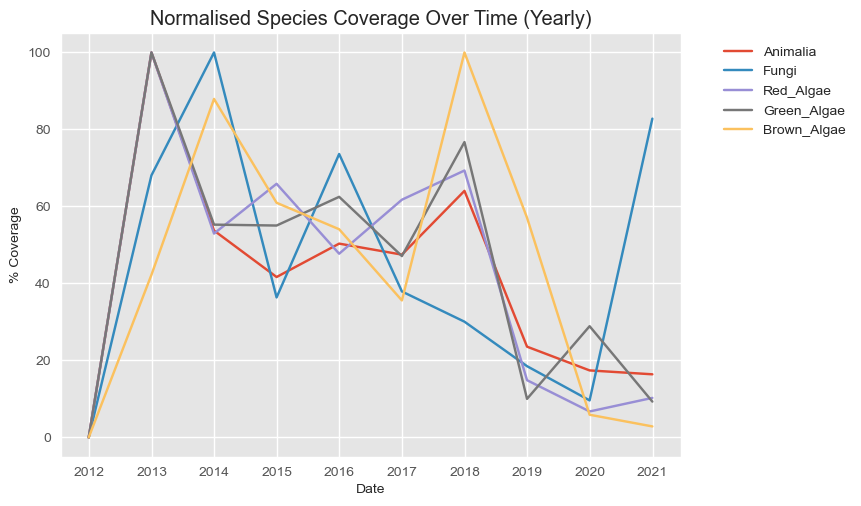

In [12]:
# plotting the normalised values to show change in % coverage across time period
sns.lineplot(sessile_yearly_sum, x='Date',y=sessile_yearly_sum['coverage']*100,hue='species')
plt.xlabel('Date')
plt.ylabel('% Coverage')
plt.title('Normalised Species Coverage Over Time (Yearly)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Findings: 

We can see here the normalised total coverage of the species on an annual basis. The highest total coverage for Animalia, Fungi and Red Algae occured before 2014. After 2014 the numbers drop and continue to drop, with the exception of fluctuations. However, the general trend is downwards. While this could be due to other factorsother than the recorded 2014 storm. 

## Visualisations: Geo-Coordinates

First we plot the area in a map.

In [13]:
# reading shape files
import glob
g = gpd.GeoDataFrame()
crs = {'init':'EPSG:4326 '}
for filepath in glob.iglob('cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_*.shp'):
    print(filepath)
    gdfs = gpd.read_file(filepath, crs= "EPSG:4326")
    g = pd.concat([g, gdfs], ignore_index=True)
    
g2 = gpd.read_file('cascais_data/batimetria/batimetria_limite.shp', crs=crs)
#g3 = gpd.read_file('cascais_data/bathymetry/Base_batimetrica.shp', crs=crs)

g = g.to_crs(epsg=4269)
g.explore()    
    

cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_A_mediolitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_A_Supralitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_B_mediolitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_B_Supralitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_D_mediolitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_D_Supralitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_E_mediolitoral.shp
cascais_data\Sampling areas Shapefiles\Areas de amostragem\Amostragem_E_Supralitoral.shp


We randomly assign locations to the samples in order to see the distribution of the species in each zone.
First we plot all samples by ignoring the coverage numbers.
The function below takes the polygons information from the shape file provided and create random points in each area and returns them as GeoDataFrame POINT data.

In [14]:
from shapely.geometry import Point, Polygon
import random

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

def points_polygon(polygon, num_points, gdf_poly):
    x,y = Random_Points_in_Bounds(polygon, num_points)
    df = pd.DataFrame()
    df['Longitude'] = x
    df['Latitude'] = y
    gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    
    Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

    pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']
    return pnts_in_poly



We now check that there are no duplicate or NaN coordinates, as well as inspect the shapefile's attributes. The points will look uniformly distributed.

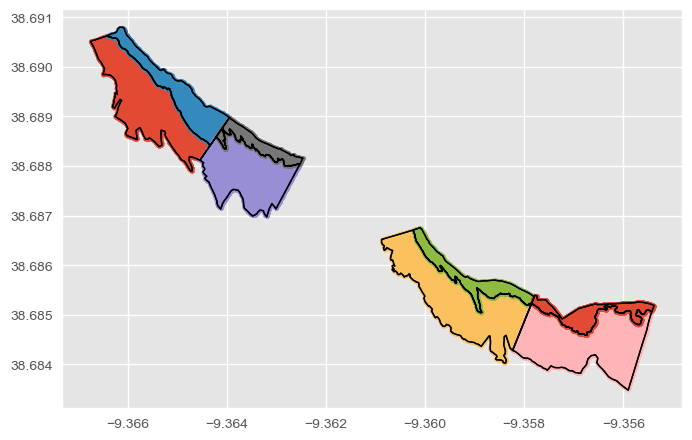

In [15]:
from pyquibbler import initialize_quibbler, iquib
initialize_quibbler()
import matplotlib.pyplot as plt
# %matplotlib tk
%matplotlib inline
points= []
base = g.boundary.plot(linewidth=1, edgecolor="black")
for i in g.index:
    polygon = g['geometry'].values[i]
    gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])
    pnts_in_poly = points_polygon(polygon, 50000, gdf_poly)
    pnts_in_poly.duplicated(subset='geometry', keep='first')
    pnts_in_poly.plot(ax=base, linewidth=1, markersize=4)
    gdf_poly.boundary.plot(ax=base, linewidth=1, edgecolor="black")
    points.append(pnts_in_poly)
    points[i] = points[i].reset_index(drop=True)

Four sampling sections (A, B, D, E), which were stratified in supratidal and middle-intertidal areas. Sections B and D were located inside the ZIBA, while sections A and E were located outside the ZIBA.

For visualization later, we are going to use the coordinates of the area named 'Área Marinha Protegida das Avencas' which available on OpenStreeMap.

In [16]:
import osmnx as ox 
place1 = ox.geocode_to_gdf('Área Marinha Protegida das Avencas')
place1 = ox.project_gdf(place1)
place1


geometry  bbox_north  bbox_south  \
0  POLYGON ((468039.736 4282378.295, 468303.868 4...   38.692273   38.683554   

   bbox_east  bbox_west   place_id osm_type     osm_id        lat       lon  \
0   -9.35568   -9.36749  220856597      way  543901152  38.687726 -9.362181   

                                        display_name    class            type  \
0  Área Marinha Protegida das Avencas, Rua de Tim...  leisure  nature_reserve   

   importance  
0     0.50001

We create new columns (Longitude and Latitude) in the dataframe to assign locations to the samples.

In [17]:
#initialize
df_sessile['Longitude'] = 0
df_sessile['Latitude'] = 0

df_sessile['Longitude'][(df_sessile['Zone'] =='A') & (df_sessile ['intertidal'] == 'Medium')] = points[0]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'A') & (df_sessile ['intertidal'] == 'Medium')] = points[0]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='A') & (df_sessile ['intertidal'] == 'Supra')] = points[1]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'A') & (df_sessile ['intertidal'] == 'Supra')] = points[1]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='B') & (df_sessile ['intertidal'] == 'Medium')] = points[2]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'B') & (df_sessile ['intertidal'] == 'Medium')] = points[2]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='B') & (df_sessile ['intertidal'] == 'Supra')] = points[3]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'B') & (df_sessile ['intertidal'] == 'Supra')] = points[3]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='D') & (df_sessile ['intertidal'] == 'Medium')] = points[4]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'D') & (df_sessile ['intertidal'] == 'Medium')] = points[4]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='D') & (df_sessile ['intertidal'] == 'Supra')] = points[5]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'D') & (df_sessile ['intertidal'] == 'Supra')] = points[5]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='E') & (df_sessile ['intertidal'] == 'Medium')] = points[6]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'E') & (df_sessile ['intertidal'] == 'Medium')] = points[6]['Latitude']
df_sessile['Longitude'][(df_sessile['Zone'] =='E') & (df_sessile ['intertidal'] == 'Supra')] = points[7]['Longitude']
df_sessile['Latitude'][(df_sessile['Zone'] == 'E') & (df_sessile ['intertidal'] == 'Supra')] = points[7]['Latitude']

df_sessile = df_sessile[df_sessile.Zone != "F"]
bools=(df_sessile['Longitude']!=None)
print(bools.sum())
df_sessile['Longitude'] = df_sessile['Longitude'] + np.random.normal(0, 0.0001, len(df_sessile)) 
df_sessile['Latitude'] = df_sessile['Latitude'] + np.random.normal(0, 0.0001, len(df_sessile)) 


1888


We form the data to combine all species coverage in one column, we name it percentage, and we will have the species name in a new column named species. 

In [18]:
df_sessile = df_sessile.drop(columns=['Animalia', 'Fungi', 'Red_Algae', 'Green_Algae', 'Brown_Algae', 'TOTAL2', 'total_check'])

df = df_sessile.melt(id_vars=["Date", "Hour", "Tide", "Weather", "WaterTemperature", "Zone", "intertidal", "Substrate", "Longitude", "Latitude"], 
        var_name="species", 
        value_name="percentage")
df['kingdom'] = df['species'].map(my_dictionary)

In [24]:
import datetime
def get_hours(test_list):
    digits = re.findall(r"[-+]?(?:\d*\d+)", str(test_list))
    result_set = [int(ele) for ele in digits]
    if len(result_set)==2:
        result_set.append(0) 
    time_1 = datetime.time(int(result_set[0]),int(result_set[1]),int(result_set[2]))
    return time_1  

df["Weather"] = df["Weather"].astype("category")
df["Zone"] = df["Zone"].astype("category")
df["intertidal"] = df["intertidal"].astype("category")
df["Substrate"] = df["Substrate"].astype("category")
df["species"] = df["species"].astype("category")

df['percentage'] = np.nan_to_num(df['percentage'])
df['percentage'] = df['percentage'].astype(str)
df['percentage'] = [re.sub("[ :^A-ZÃÀÉ]", "0", s) for s in df['percentage']]
df['percentage'] = [re.sub("[:]", "0", s) for s in df['percentage']]
df['percentage'] = [re.sub(r"[^0-9][-]", "0", s) for s in df['percentage']]
df['percentage'] = [re.sub(r"[^0-9][:]", "0", s) for s in df['percentage']]
df['Date'] = pd.to_datetime(df.Date).astype(str)
df['WaterTemperature'] = pd.to_numeric(df['WaterTemperature'], errors='coerce')
df['percentage'] = pd.to_numeric(df['percentage'], errors='coerce')
df['Tide'] = pd.to_numeric(df['Tide'], errors='coerce')
df['Hour'] = df['Hour'].apply(get_hours)
df.sort_values(['Date','Hour'], inplace=True)

isDuplicate = df.duplicated(keep = 'first')
df = df[~isDuplicate]
print(isDuplicate.value_counts())
df.head()

False    173696
dtype: int64


Date      Hour  Tide    Weather  WaterTemperature Zone intertidal  \
2     2011-11-28  10:10:00   0.6  Clear sky              16.0    D     Medium   
1890  2011-11-28  10:10:00   0.6  Clear sky              16.0    D     Medium   
3778  2011-11-28  10:10:00   0.6  Clear sky              16.0    D     Medium   
5666  2011-11-28  10:10:00   0.6  Clear sky              16.0    D     Medium   
7554  2011-11-28  10:10:00   0.6  Clear sky              16.0    D     Medium   

     Substrate  Longitude   Latitude               species  percentage  \
2       Puddle  -9.359677  38.685042        Chthamalus sp.         0.0   
1890    Puddle  -9.359677  38.685042    Balanus perforatus         0.0   
3778    Puddle  -9.359677  38.685042           Patella sp.         0.0   
5666    Puddle  -9.359677  38.685042  Siphonaria algesirae         0.0   
7554    Puddle  -9.359677  38.685042           Gibbula sp.         0.0   

      kingdom  
2         1.0  
1890      1.0  
3778      1.0  
5666      1.0  
7554      1.0

Here we plot create an interactive map to show the species locations in a specific day. We randomly select '2012-01-12'.  The samples with 0% coverage should be removed.

In [20]:
dates_str = [str(x) for x in df['Date']] 
idx = [i for i, e in enumerate(dates_str) if e == '2012-01-12']
day_df = df.iloc[idx]
day_df = day_df[day_df['percentage']>0]


In [21]:
import folium
from folium.plugins import MarkerCluster

map = folium.Map(width='92%',  location=[place1.lat, place1.lon], 
zoom_start=15, prefer_canvas=True)         

title_html = '''
        <h5 align="center"; margin-bottom=0px; padding-bottom=0px; style="font-size:20px"><b>Species population density in Cascais ( Date: 2012-01-12 )</b></h3>
        <h5 align="center"; margin-top=0px; padding-top=0px; style="font-size:14px">Click on the blue circles for more info</h3>
              '''
map.get_root().html.add_child(folium.Element(title_html))

# Create a marker for each record and format popup

marker_cluster = folium.plugins.MarkerCluster().add_to(map)
for index, row in day_df.iterrows():
    html = f"""<strong>Species:</strong> {row['species']}<br>
        <br>
        <strong>Zone:</strong> {row['Zone']}<br>
        <br>
        <strong>Coverage:</strong> {row['percentage']}<br>
        <br>
        <strong>intertidal:</strong> {row['intertidal']}<br>
        <br>
        <strong>Substrate:</strong> {row['Substrate']}<br> 
            """
    iframe = folium.IFrame(html,
                       width=200,
                       height=200)
    popup = folium.Popup(iframe,
                     max_width=400)
    folium.Marker(location=[row["Latitude"], row["Longitude"]],
                                         radius=10,
                                         color="#3186cc",
                                         fill=True, 
                                         fill_color="#3186cc",  
                                      popup=popup).add_to(marker_cluster)

    
map.save("index.html")
map

#### This interactive map can help users analyze the spatial distribution of the species population. We know that the coordinates are not correctly provided, but it is sure that they are presented in the correct zone. Consequently, the spatially derived simulations can reflect the spatial variation of marine species of Avencas protected zone and adjoining areas. Depending upon these visual modeling of different species data and their spatial variation for ten consecutive years, our proposal is to create a predictive simulation model that can represent the behavior of marine life in the area, i.e., a predictive model can predict and visualize the species population distribution in the future. In this way, a suitable strategy could be formulated to ameliorate the species extinction problem. 


We can also visualizate with other parameters. Let's select one species and plot them by intertidal level. We will not include the samples have 0 %. We can see that during the whole data collection period between 2011-2020, this species appeared more on the upperside of the area.

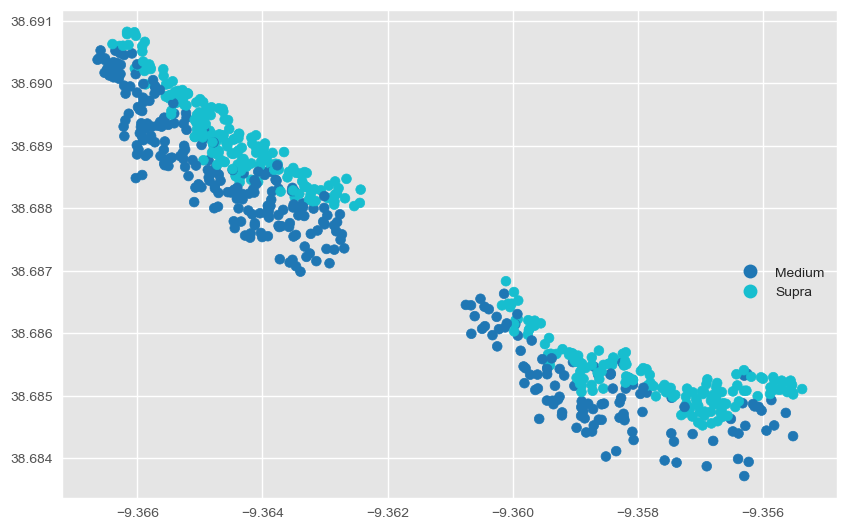

In [25]:
dfChthamalus = []
dfChthamalus = df[df["species"]=="Chthamalus sp."][['intertidal', 'percentage', 'Longitude', 'Latitude']]
dfChthamalus =  dfChthamalus[dfChthamalus["percentage"].astype(int)>0]

# plot the points geographically for Chthamalus species 
fig, ax = plt.subplots(figsize=(10,10))
gpd1 = gpd.GeoDataFrame(
    dfChthamalus, geometry=gpd.points_from_xy(dfChthamalus.Longitude, dfChthamalus.Latitude), crs=crs,
)
sp = gpd1.plot(
    column='intertidal',
    ax=ax,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1, 0.5)},
    aspect=1
)

Now, let's see correlation between variables to summarize the direct relationship between two variables. 

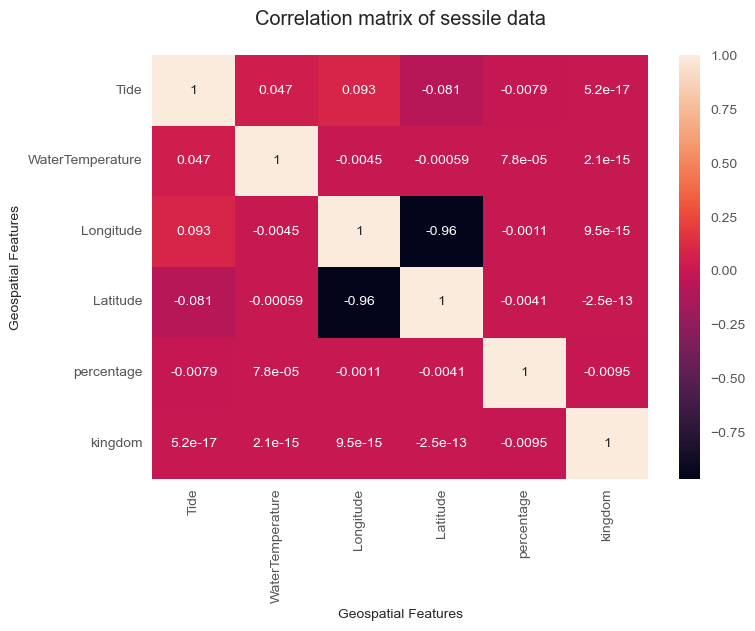

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
hm = sns.heatmap(df.corr(), annot = True)
hm.set(xlabel='Geospatial Features', ylabel='Geospatial Features', title = "Correlation matrix of sessile data\n")
plt.show()

This correlation matrix plot shows only numeric variables. Correlation doesn’t imply causation. We don't use it to predict or explain the numeric response.

We define the problem as predicting the coverage of species given variables. Therefore it is a regression problem. First, we prepare the data to create a model. Before setting our model, we convert the variables (Weather, Zone, intertidal, Substrate, species) to categorical variables.


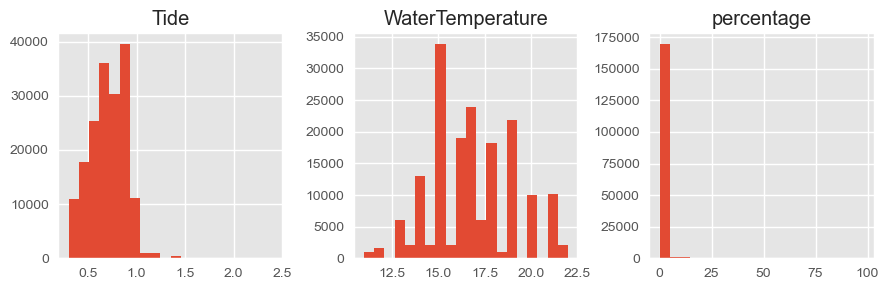

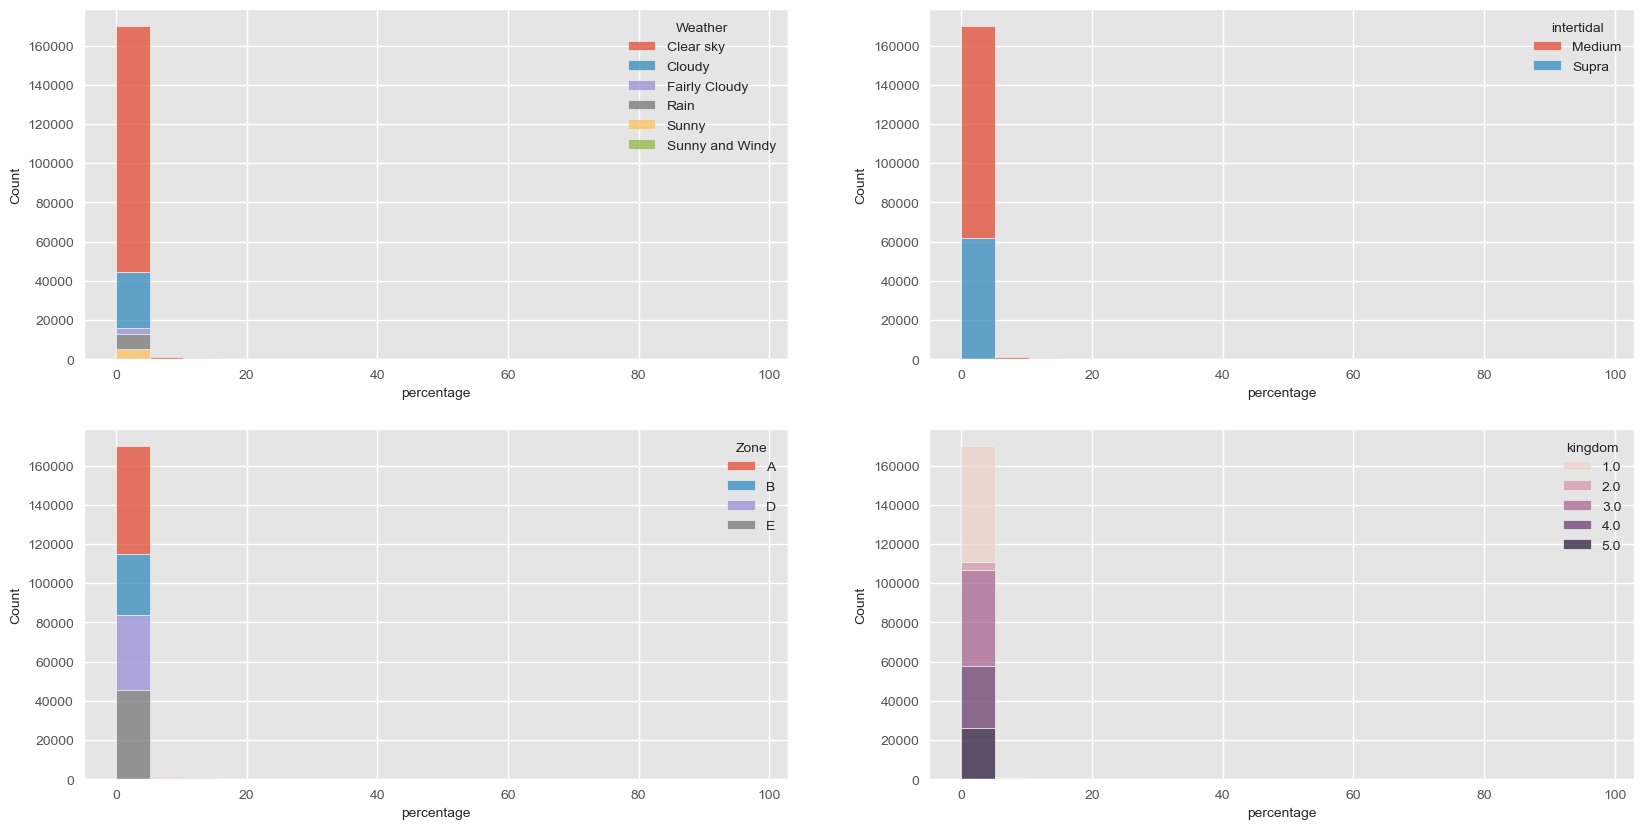

In [27]:
numerical = ['Tide', 'WaterTemperature', 'percentage']

df[numerical].hist(bins=20, layout=(1, 3), figsize=(9,3))
plt.tight_layout()
plt.show()

categorical = ['Weather', 'intertidal', 'Zone', 'kingdom']

fig, axs = plt.subplots(2, 2, figsize=(20,10))
for variable, ax in zip(categorical, axs.flatten()):
  sns.histplot(df, x='percentage', hue=variable, multiple='stack', ax=ax)



The target variables 'percentage' are not normally distributed. We will need to consider this in our model.


Now that we've gleaned some useful insight from EDA, let's begin the process for regression on this data.

### Regression 

In [28]:
df_enc = df.copy()
enc = OneHotEncoder(sparse=False)
df_encode = pd.DataFrame(enc.fit_transform(df[["Weather", "Zone", "intertidal", "Substrate"]]))
df_enc = df.join(df_encode)
df_enc.drop(columns=['Date', 'Hour', 'Weather', 'Zone', 'Substrate', 'intertidal', 'Longitude', 'Latitude'], inplace=True)
df_enc.head()

Tide  WaterTemperature               species  percentage  kingdom    0  \
2      0.6              16.0        Chthamalus sp.         0.0      1.0  1.0   
1890   0.6              16.0    Balanus perforatus         0.0      1.0  1.0   
3778   0.6              16.0           Patella sp.         0.0      1.0  1.0   
5666   0.6              16.0  Siphonaria algesirae         0.0      1.0  1.0   
7554   0.6              16.0           Gibbula sp.         0.0      1.0  1.0   

        1    2    3    4  ...   26   27   28   29   30   31   32   33   34  \
2     0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1890  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3778  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5666  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7554  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       35  
2     0.0  
1890  0.0  
3778  0.0  
5666  0.0  
7554  0.0  

[5 rows x 41 columns]

In [29]:
column_names = ['Tide', 'WaterTemperature', 'Weather1','Weather2','Weather3','Weather4','Weather5','Weather6','Zone1','Zone2','Zone3','Zone4',
   'intertidal','intertidal', 'Substrate1', 'Substrate21', 'Substrate3', 'Substrate4', 'Substrate5', 'Substrate6',
                'Substrate7', 'Substrate8', 'Substrate9', 'Substrate10', 'Substrate11', 'Substrate12', 'Substrate13',
                'Substrate14', 'Substrate15', 'Substrate16', 'Substrate17', 'Substrate18', 'Substrate19', 'Substrate20']


One-hot-encoding creates one additional feature per category value.

In [30]:
y = df_enc['percentage']
X = df_enc.drop(columns=['percentage'])
y = y.astype(str).astype('float')
y = np.nan_to_num(y)
#X['Weather'] = X['Weather'].astype(int).astype('category')
#X['Zone'] = X['Zone'].astype(int).astype('category')
#X['intertidal'] = X['intertidal'].astype(int).astype('category')
#X['Substrate'] = X['Substrate'].astype(int).astype('category')
#X['species'] = X['species'].astype(int).astype('category')
print(X.shape, y.shape)


(173696, 40) (173696,)


First let's create a model for one species data. We select one and drop the column. Before training a model, we can check the importance of features on regression.

In [31]:
Xtrain = X[X['species']=='Chthamalus sp.']
ytrain = y[X['species']=='Chthamalus sp.']
Xtrain.drop(columns=['species', 'kingdom'], inplace=True)
print(Xtrain.shape, ytrain.shape)

(1888, 38) (1888,)


In [32]:
column_names = Xtrain.columns
Xtrain.columns = [''] * len(Xtrain.columns)

Feature: 0, Score: 0.33932
Feature: 1, Score: 0.35832
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.04863
Feature: 9, Score: 0.00988
Feature: 10, Score: 0.01761
Feature: 11, Score: 0.02943
Feature: 12, Score: 0.01913
Feature: 13, Score: 0.08964
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00976
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.01518
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.06311
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

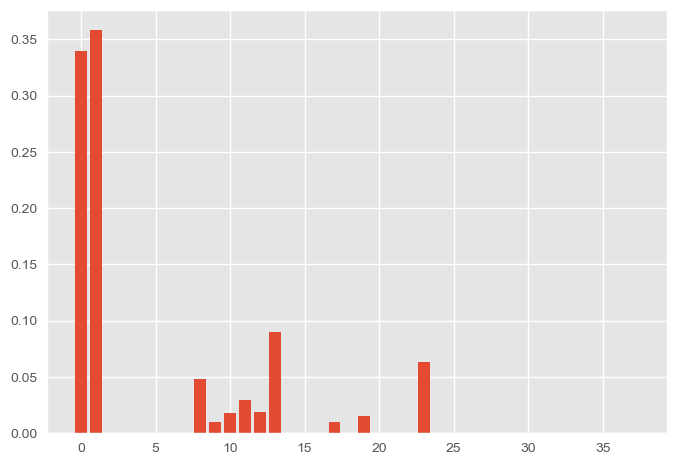

Index([            'Tide', 'WaterTemperature',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10,                 11,                 12,
                       13,                 14,                 15,
                       16,                 17,                 18,
                       19,                 20,                 21,
                       22,                 23,                 24,
                       25,                 26,                 27,
                       28,                 29,                 30,
                       31,                 32,                 33,
                       34,                 35],
      dtype='object')


In [33]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(Xtrain, ytrain)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
print(column_names)

We can see that Tide and WaterTemperature are important features. Intertidal categorical feature is found to be important as well.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, ytrain, test_size = 0.2, random_state = 42)

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

R^2 Training Score: 0.16 
OOB Score: -0.06 
R^2 Validation Score: -0.03


 The model performance is very low, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set.
 Also, this approach is not good for our prediction problem. Because we divided the train and test set randomly using train_test_split function and we did not take into account time information. 
 
 ##### Now let's restart the process adding this information to the model. There are many regression algorithms, and it is not always obvious which one is optimal for our dataset. To find the best model, we test a number of them and compare the results. PyCaret library provides fast solution for this.

### PyCaret Regression Module

PyCaret is an open-source, machine learning python library. It automates machine learning workflow. PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (called the ‘outcome variable’, or ‘target’) and one or more independent variables (called ‘features’, or ‘predictors’).

PyCaret provide many pre-processing features to prepare the data for modeling through the setup function. Having ready-to-use algorithms we can create several plots to analyze the performance of trained models.

By default, PyCaret regression module uses k-fold random cross-validation when evaluating models. The default cross-validation setting is not suitable for time-series data. In this problem, we need different kind of cross-validation since the model needs to respect the order of dates. 
We can change default settings easily to make it work for time series data, using the parameter fold_strategy = 'timeseries' in setup() function.

As a baseline method, we use one of the Classical/Statistical Models, Moving Averages. It is obtained by summing the recent data points in a given set (in our case it is 8) and dividing the total by the number of time periods.

In [38]:
df_enc = df.copy()
enc = OrdinalEncoder()
df_enc[["Weather","species", "Zone", "Substrate", "intertidal"]] = enc.fit_transform(df_enc[["Weather","species", "Zone", "Substrate", "intertidal"]])
df_species = df_enc[df_enc['species'] == 0] 
data = df_species[['Date', 'Tide', 'Weather', 'WaterTemperature', 'Zone', 'intertidal',
       'Substrate', 'percentage', 'kingdom']]
data = data[data['percentage'] > 0] 
data['Date'] = pd.to_datetime(data['Date'])
data['Weather'] = data['Weather'].astype(int).astype('category')
#data['species'] = data['species'].astype('category')
data['intertidal'] = data['intertidal'].astype(int).astype('category')
data['Substrate'] = data['Substrate'].astype(int) .astype('category')
data['Zone'] = data['Zone'].astype(int).astype('category')
data['kingdom'] = data['kingdom'].astype(int).astype('category')

# create 8 moving average
data['MA8'] = data['percentage'].rolling(8).mean()# plot the data and MA
dataMA8 = data['MA8']
import plotly.express as px
fig = px.line(data, x="Date", y=["percentage", "MA8"], template = 'plotly_dark')
fig.show()

Note: You will need to run the notebook to be able to see the interactive plot here.  In case you can't, we attach it as png file.
! [Prediction1] (https://github.com/mineysm/WDL_2023/blob/main/newplot1.png)
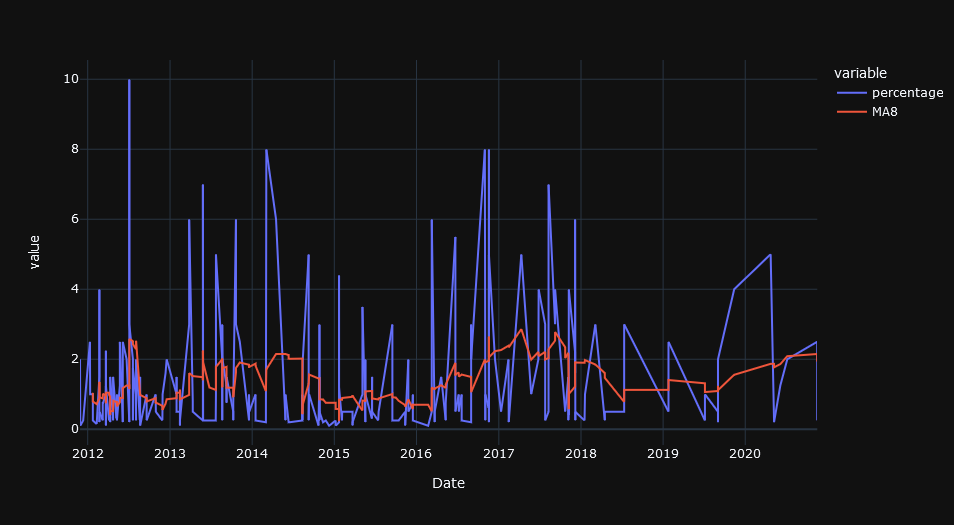

Let’s extract some simple features from dates such as month and year, and drop the original date column.


In [39]:
# extract month and year from dates
data['Month'] = [i.month for i in data['Date']]
data['Year'] = [i.year for i in data['Date']]# create a sequence of numbers
data['Series'] = np.arange(1,len(data)+1)# drop unnecessary columns and re-arrange
#data.drop(['MA8'], axis=1, inplace=True)
data = data[['Series', 'Year', 'Month', 'Date', 'Zone', 'Weather', 'percentage', 'Tide', 'WaterTemperature', 'Substrate', 'kingdom']] # check the head of the dataset
data.head()

Series  Year  Month       Date Zone Weather  percentage  Tide  \
20771       1  2011     11 2011-11-28    2       0        2.00   0.6   
20772       2  2011     11 2011-11-28    2       0        0.75   0.6   
20774       3  2011     11 2011-11-28    3       0        0.75   0.6   
20787       4  2011     11 2011-11-29    0       0        0.10   0.8   
20800       5  2011     12 2011-12-12    3       0        0.25   0.9   

       WaterTemperature Substrate kingdom  
20771              16.0         9       1  
20772              16.0         9       1  
20774              16.0         9       1  
20787              16.0         5       1  
20800              16.0         9       1

Before initializing the setup, we have manually split the dataset to avoid shuffling the dataset before the split.
Then, we can initialize the setup function, where we will explicitly pass the training data, test data, and cross-validation strategy using the fold_strategy parameter.

As we've noticed in the EDA section, the target variable is right-skewed. Because many regression algorithms expect the data to have a normal distribution to perform optimally, this could cause problems. Therefore in the setup() function we give the option to transform the target to have a distribution close to normal. 

In [40]:
# split data into train-test set
train = data[data['Year'] < 2018]
test = data[data['Year'] >= 2018]# check shape
traindate = data[data['Year'] < 2018]['Date']
testdate = data[data['Year'] >= 2018]['Date']
train.shape, test.shape

#intialize setup
s = setup(data = train, test_data = test, target = 'percentage', fold_strategy = 'timeseries', imputation_type='simple', normalize_method='z-score',
          numeric_features = ['Year', 'Month', 'Series', 'Tide', 'WaterTemperature'], fold = 3, transform_target = True, session_id = 123)


The data types for all input features are inferred and pre-processing tasks are performed on the data. After setup, transformed data is available for model training.

#### Comparing Different Models 
The function below compares a variety of different models. Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are widely used regression metrics for measuring the performance of regression machine learning models. The difference is how they behave when outliers are present in the dataset. Both metrics are returning the error on the same scale as the coverage percentages we are predicting, but the RMSE is higher as there are outliers in the dataset which increase the error.


In [41]:
best = compare_models(sort = 'RMSE')

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

 The table shows each model's name, and the rest of the columns are various metrics. We focus on RMSE for now. In MAE and RMSE, we simply look at the “average difference” between two values. 
 The best model based on cross-validated MAE is Least Angle Regression. It is a type of forward step-wise regression. LAR is  generally used in regression for high dimensional data. However, the predictor gives us little or no information about the actual observations (low R2).

Let’s plot the actual and predicted lines to visualize the fit.

In [42]:
predictions = predict_model(best, data=data)
predictions['Date'] = data['Date']
#predictions['Date'] = pd.date_range(start='2011-01-01', end='2021-01-01', periods=len(data)) # x axis
# to show test-set separation
fig = px.line(predictions, x='Date', y=["percentage","prediction_label"], template = 'plotly_dark')
fig.add_vrect(x0="2017-01-01", x1="2021-12-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

! [Prediction1] (https://github.com/mineysm/WDL_2023/blob/main/newplot1.png)


In this plot we the predictions and real values of the percentage data. From 2012-2017 the samples are from the train data and shaded area after 2017 shows the test data and predictions. We see that they don't fit well after the training part .

To improve the overall effectiveness of the model, ensemble learning combines many models. Blending is one of the ensemble learning techniques that calculates how to blend predictions from several ensemble member models in the most effective way. 
Now let's try some of the other models in the previous table. Instead of training each model, we will use "pycaret.regression.blend_models()" function. Blend model function trains a Soft Voting / Majority Rule classifier for selected models passed in the "estimator_list" parameter.

In [43]:
lar = create_model('lar', verbose = False)
knn = create_model('knn', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
gbr = create_model('gbr', verbose = False)
blend_specific = blend_models(estimator_list = [lar,knn,lightgbm,gbr])


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
final_model = finalize_model(blend_specific)
predictions2 = predict_model(final_model, data=test)


MAE on the test set is higher than the cross-validated MAE. 

In [45]:
predictions2['Date'] = testdate
#predictions['Date'] = pd.date_range(start='2011-01-01', end='2021-01-01', periods=len(data)) # x axis
# to show test-set separation
fig = px.line(predictions2, x='Date', y=["percentage","prediction_label"], template = 'plotly_dark')
fig.add_vrect(x0="2017-01-01", x1="2021-12-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()


! [Prediction2] https://github.com/mineysm/WDL_2023/blob/main/newplot3.png


From this plot, we see the predictions are closer to the real values compared to baseline method and the LAR method. 


### Summary
We propose a simulation tool for forecasting the future coverage of species in spatially classified area. We create a predictive model that can take several parameters in training, the number of inputs can be increased/descreased according to performance of the model and user preferences, therefore the model is scalable. 

We have pre-processed the data, and compared a variety of regression models.
Since we have time series data that can be ordered in a sequence, we could also have used LSTM, one of the state-of-the-art models for forecasting, to model it, because it can find long-term trend in our data, and also it can deal with nonstationary of the time series data.  However we could not find the relationship between variables and time series data because there are missing dates in the dataset. The samples are not recorded periodically. Without having seasonal information, the trained model will not achieve high performance.

## 👓 References

Christian Thompson, F. (2009). Nomenclature and classification, principles of. Encyclopedia of Insects, 707–714. doi:10.1016/b978-0-12-374144-8.00191-0 

PyCaret 3.0.  https://pycaret.gitbook.io/docs/
